# Assignment - Decision Trees and Random Forests

![](https://i.imgur.com/3sw1fY9.jpg)

**We'll follow a step-by-step process:**

1. Download and prepare the dataset for training
2. Train, evaluate and interpret a decision tree
3. Train, evaluate and interpret a random forest
4. Tune hyperparameters to improve the model
5. Make predictions and save the model


Let's begin by installing the required libraries.

In [1]:
!pip install opendatasets scikit-learn plotly folium --upgrade --quiet

In [2]:
!pip install pandas numpy matplotlib seaborn --quiet

## Download and prepare the dataset for training

In [3]:
import os
from zipfile import ZipFile
from urllib.request import urlretrieve

dataset_url = 'https://github.com/JovianML/opendatasets/raw/master/data/house-prices-advanced-regression-techniques.zip'
urlretrieve(dataset_url, 'house-prices.zip')
with ZipFile('house-prices.zip') as f:
    f.extractall(path='house-prices')
    
os.listdir('house-prices')

['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']

In [4]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

prices_df = pd.read_csv('house-prices/train.csv')
prices_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [5]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Identify input and target columns
input_cols, target_col = prices_df.columns[1:-1], prices_df.columns[-1]
inputs_df, targets = prices_df[input_cols].copy(), prices_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = prices_df[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = prices_df[input_cols].select_dtypes(include='object').columns.tolist()

# Impute and scale numeric columns
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

# Create training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

/home/ayush/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_d

<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
<ipython-input-5-71b659752d06>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

## Decision Tree


In [6]:
from sklearn.tree import DecisionTreeRegressor

In [7]:
# Create the model
tree = DecisionTreeRegressor()

In [8]:
# Fit the model to the training data
tree.fit(train_inputs,train_targets)

DecisionTreeRegressor()

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
tree_train_preds = tree.predict(train_inputs)

In [11]:
tree_train_rmse = mean_squared_error(train_targets,tree_train_preds,squared=False)

In [12]:
tree_val_preds = tree.predict(val_inputs)

In [13]:
tree_val_rmse = mean_squared_error(val_targets,tree_val_preds,squared=False)

In [14]:
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Train RMSE: 0.0, Validation RMSE: 38061.4575627726


In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

[Text(0.5, 0.875, 'X[3] <= 0.722\nsquared_error = 6071445130.643\nsamples = 1095\nvalue = 181712.287'), Text(0.25, 0.625, 'X[3] <= 0.611\nsquared_error = 2386768309.629\nsamples = 920\nvalue = 158805.621'), Text(0.125, 0.375, 'X[15] <= 0.197\nsquared_error = 1454831415.59\nsamples = 676\nvalue = 141623.494'), Text(0.0625, 0.125, '\n  (...)  \n'), Text(0.1875, 0.125, '\n  (...)  \n'), Text(0.375, 0.375, 'X[15] <= 0.318\nsquared_error = 1884732106.418\nsamples = 244\nvalue = 206408.561'), Text(0.3125, 0.125, '\n  (...)  \n'), Text(0.4375, 0.125, '\n  (...)  \n'), Text(0.75, 0.625, 'X[3] <= 0.833\nsquared_error = 8181966681.482\nsamples = 175\nvalue = 302135.903'), Text(0.625, 0.375, 'X[15] <= 0.309\nsquared_error = 4342623257.511\nsamples = 130\nvalue = 275435.285'), Text(0.5625, 0.125, '\n  (...)  \n'), Text(0.6875, 0.125, '\n  (...)  \n'), Text(0.875, 0.375, 'X[13] <= 0.807\nsquared_error = 11264021224.955\nsamples = 45\nvalue = 379271.022'), Text(0.8125, 0.125, '\n  (...)  \n'), Text(

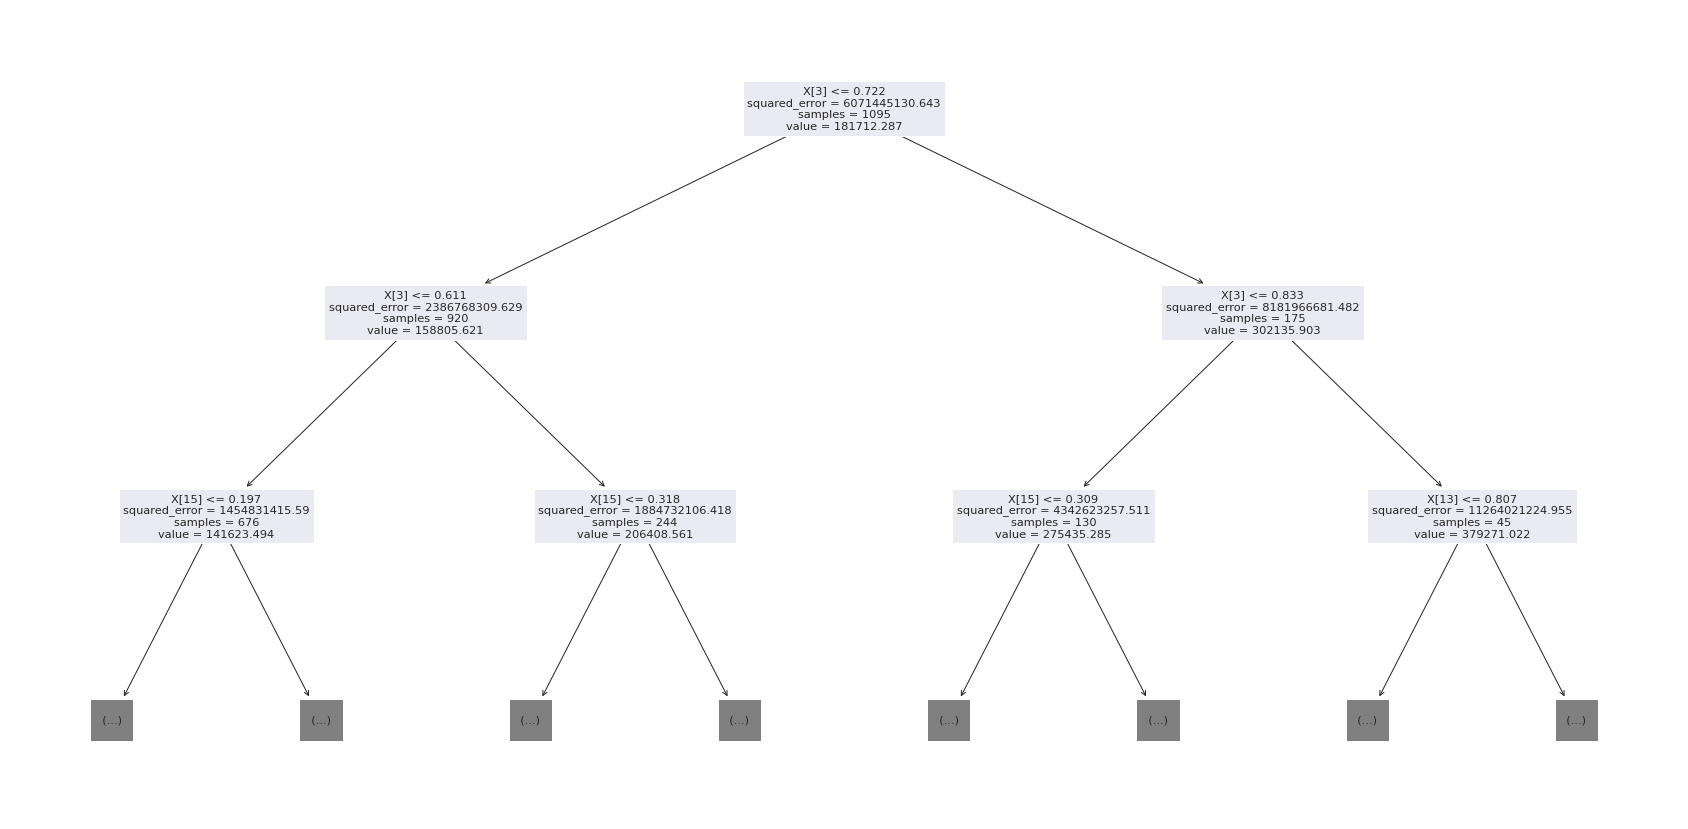

In [16]:
plt.figure(figsize=(30,15))

# Visualize the tree graphically using plot_tree
tree_plot = plot_tree(tree,max_depth=2)
print(tree_plot)

In [17]:
# Visualize the tree textually using export_text
tree_text = export_text(tree)

In [18]:
# Display the first few lines
print(tree_text[:2000])

|--- feature_3 <= 0.72
|   |--- feature_3 <= 0.61
|   |   |--- feature_15 <= 0.20
|   |   |   |--- feature_11 <= 0.16
|   |   |   |   |--- feature_3 <= 0.39
|   |   |   |   |   |--- feature_270 <= 0.50
|   |   |   |   |   |   |--- feature_2 <= 0.04
|   |   |   |   |   |   |   |--- feature_224 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_11 <= 0.06
|   |   |   |   |   |   |   |   |   |--- value: [52000.00]
|   |   |   |   |   |   |   |   |--- feature_11 >  0.06
|   |   |   |   |   |   |   |   |   |--- feature_248 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_138 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [100000.00]
|   |   |   |   |   |   |   |   |   |   |--- feature_138 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [97000.00]
|   |   |   |   |   |   |   |   |   |--- feature_248 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_60 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2

In [19]:
# Check feature importance
tree_importances = tree.feature_importances_

In [20]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [21]:
tree_importance_df

,feature,importance
3,OverallQual,0.632441
15,GrLivArea,0.105893
13,2ndFlrSF,0.031001
12,1stFlrSF,0.028447
11,TotalBsmtSF,0.027350
...,...,...
103,Condition2_RRAe,0.000000
102,Condition2_PosN,0.000000
101,Condition2_PosA,0.000000
100,Condition2_Norm,0.000000


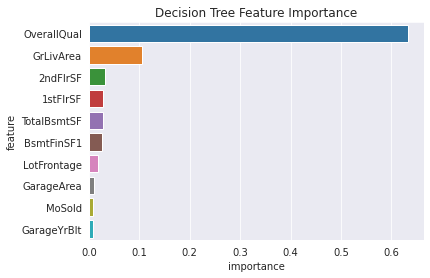

In [22]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

## Random Forests


In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
# Create the model
rf1 = RandomForestRegressor()

In [25]:
# Fit the model
rf1.fit(train_inputs,train_targets)

RandomForestRegressor()

In [26]:
rf1_train_preds = rf1.predict(train_inputs)

In [27]:
rf1_train_rmse = mean_squared_error(train_targets,rf1_train_preds,squared=False)

In [28]:
rf1_val_preds = rf1.predict(val_inputs)

In [29]:
rf1_val_rmse = mean_squared_error(val_targets,rf1_val_preds,squared=False)

In [30]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 11408.713246432964, Validation RMSE: 27836.135837798953
